## <u><b>시계열 데이터 예측하기 - 단변량 시계열 데이터 예측하기
<b> 참고: https://bit.ly/3kTvOtx, https://bit.ly/3JsfUR7, https://bit.ly/3HJfnsN
> <b> 데이터셋 살펴하기 <br/>
    온도 데이터 추출 <br/>
    표준화(Standardization)<br/>
    첫번째 예측 <br/>
    순환 신경망 사용하기 <br/>
    LSTM

예측에 사용할 시계열 데이터는 독일의 Max Planck Institute for Biogeochemistry에서 관측한 날씨 데이터셋 이다.<br/>
이 날씨 데이터셋은 2003년 이후 10분 간격으로 관측된 온도, 대기압, 습도와 같은 14종류의 다양한 관측치를 포함하고 있다.<br/>
편의를 위해 2009년부터 2016년 사이의 데이터만 사용했다. <br/>

### <b>데이터셋 살펴보기

`df.head()`는 DataFrame 객체의 작은 샘플을 보기 위해 사용되며, 입력한 숫자만큼의 행을 출력하지만 기본적으로 5개의 행을 출력하도록 되어있다.<br/>
출력 결과를 통해 날짜-시간, 대기압, 온도 등의 순서로 15개의 열 (column)을 갖고, 10분 간격으로 기록된 데이터임을 알 수 있다. <br/>
따라서 하루에 144 (6×24)개의 데이터들이 존재한다. <br/>

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

df = pd.read_csv('./Data/jena_climate_2009_2016.csv')
print(df.head())
print(df.columns)

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

<br/>
뉴럴네트워크 모델을 훈련하는데 사용할 특정한 시간 윈도우의 데이터를 얻기 위해 아래의 함수를 사용한다. <br/>
`history_size`는 과거 데이터의 크기를 의미한다. <br/>
`target_size`는 모델이 얼마 동안의 미래를 예측할지를 의미한다. <br/>

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

<br/>
데이터셋의 앞에서부터 300,000개 행의 데이터를 훈련에 사용하고, 이후의 데이터들을 검증 (validation)에 사용하기 위해 나눈다. <br/>
300,000개의 데이터는 약 2,083일 정도의 데이터이며, 재현성을 보장하기 위해 시드를 설정한다. <br/>

In [4]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

### <b>온도 데이터 추출

In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64


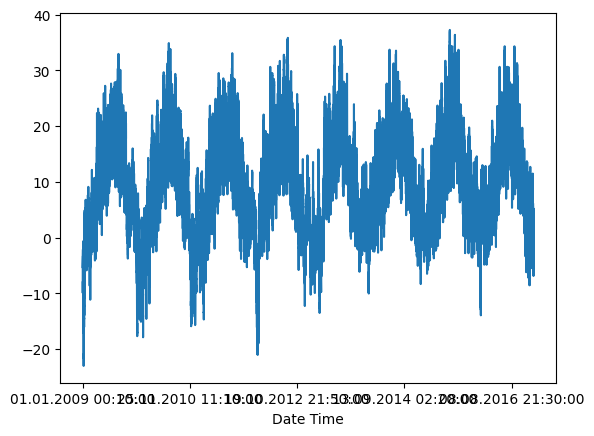

In [7]:
uni_data.plot(subplots=True) # 시간에 따른 온도 변화 그래프
plt.show()

### <b> 표준화(Standardization)

온도 데이터에 대해서, 평균을 빼고 표준편차로 나누어줌으로써 표준화 진행

In [8]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

print(uni_data)

[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


### <b> 첫번째 예측
먼저 20개의 온도 관측치를 입력하면 다음 시간 스탭의 온도를 예측하는 단변량 모델을 위한 데이터 생성하기 <br/>
<br/>
아래 출력 결과는 `univariate_data()` 함수가 만든 20개 과거 온도 데이터와 1개의 목표 예측 온도를 나타낸다. 

In [9]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [12]:
'''
create_time_steps() : 데이터의 길이를 이용하여 시간 스탭 값 생성
show_plot() : matplotlib를 활용하여 온도 데이터 그래프 시각화
'''
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

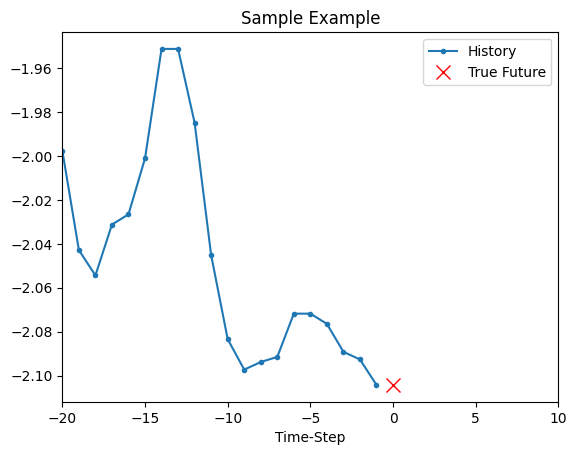

In [15]:
# 파란 마커가 20개의 과거 온도 데이터, 빨간 마커가 예측해야 할 미래의 (실제) 온도 데이터
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

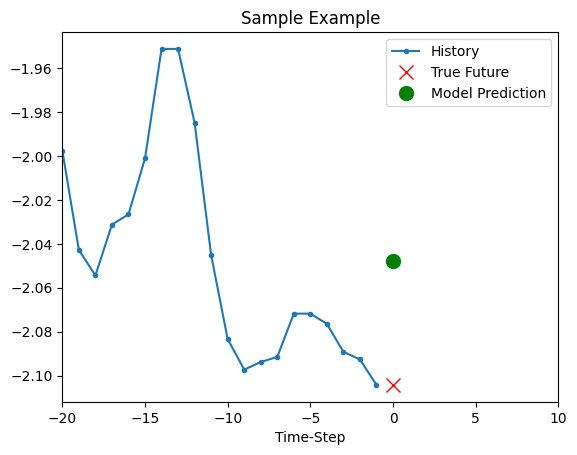

In [18]:
# 과거 20개 데이터를 받아 그 평균을 반환하는 함수
# 녹색 마커는 과거 온도 데이터의 평균값을 이용하여 예측한 지점 -> 실제 데이터와 꽤 차이 큼

def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

### <b> 순환 신경망 사용하기
순환 신경망 (Recurrent Neural Network)은 시계열 데이터에 적합한 형태의 신경망으로, 입력된 데이터들에 대한 정보를 유지하면서 시계열 데이터를 처리한다.

- <b> shuffle, batch, cache </b> <br/>
    `tf.data`를 이용해서 데이터셋을 shuffle, batch, cache하는 작업 수행 <br/>
    tf.data.Dataset의 `from_tensor_slices()`는 주어진 텐서들 ((x_train_uni, y_train_uni))을 첫번째 차원을 따라 슬라이스하며, 모든 입력 텐서는 첫번째 차원과 같은 크기를 가져야 한다.
    - `cache()` : 데이터셋을 캐시, 즉 메모리 또는 파일에 보관합니다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용
    - `shuffle()` : 데이터셋을 임의로 섞어줌. BUFFER_SIZE개로 이루어진 버퍼로부터 임의로 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체. 완벽한 셔플을 위해서 전체 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구됨.
    - `batch()` : 데이터셋의 항목들을 하나의 배치로 묶어줌

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### <b> LSTM (Long Short Term Memory)
LSTM은 순환 신경망 (RNN)의 특수한 형태이다.

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10


2023-01-31 16:10:16.549329: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-31 16:10:16.551540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 16:10:16.702496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 16:10:17.162096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


199/200 [============================>.] - ETA: 0s - loss: 0.4079

2023-01-31 16:10:22.144438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 16:10:22.197776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 7s 27ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0443 - val_loss: 0.0257
Epoch 5/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0286 - val_loss: 0.0208
Epoch 8/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0228 - val_loss: 0.0174


2023-01-31 16:12:01.765143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 16:12:01.812812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 8ms/step


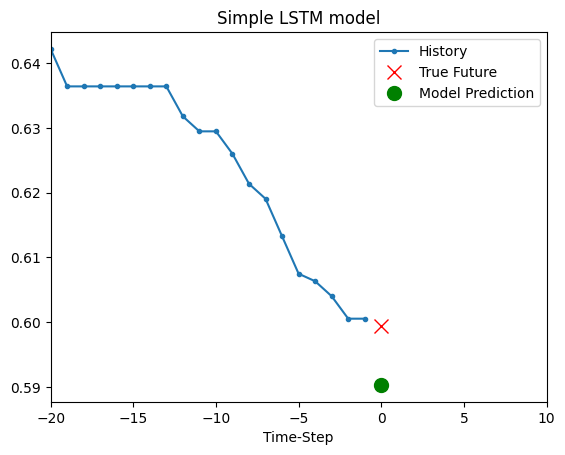

8/8 [==============================] - 0s 11ms/step


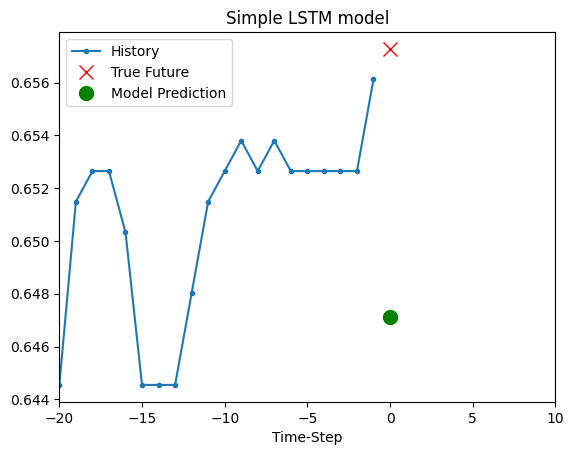

8/8 [==============================] - 0s 8ms/step


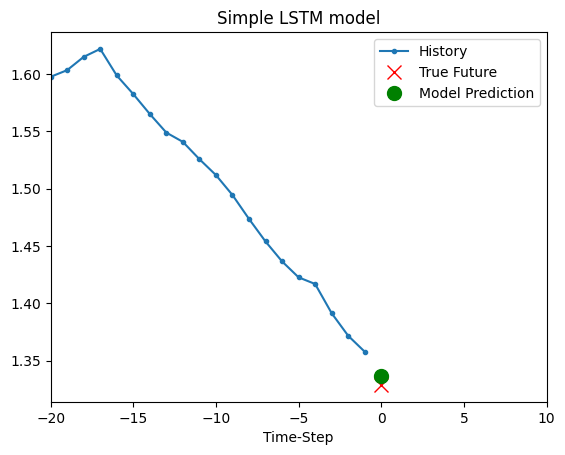

In [24]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()